# Alexnet

IA para identificar imágenes

# Temas a tratar

* Redes neuronales artificiales.
* Capas densas y convolucionales.
* Clasificación con redes neuronales.
* Aprendizaje de redes neuronales.
* Visión por computadora.
* Aprendizaje por transferencia.

# Objetivo

Desarrollar un modelo de inteligencia artificial (IA) que dada una imagen identique el elemento que se quiere representar.

# Problema

El ILSVRC (ImageNet Large Scale Visual Recognition Challenge) es una competencia anual que busca mejorar la precisión en el reconocimiento visual. Fue creado en 2010 como una colaboración entre el desafío PASCAL VOC y el proyecto ImageNet. El objetivo es evaluar algoritmos en un conjunto de datos dado y competir por lograr una mayor precisión en tareas de reconocimiento visual.

En la competencia se utiliza una lista de 1000 categorías de imágenes, incluyendo 90 razas de perros clasificadas por el esquema completo de ImageNet. En la década de 2010, hubo un progreso significativo en el procesamiento de imágenes.

# Solución

En 2012, se logró una tasa de error de clasificación en el top-5 del 16% con una red neuronal convolucional profunda llamada AlexNet. En los años siguientes, las tasas de error mejoraron aún más.

En 2015, investigadores de Microsoft informaron que sus redes neuronales convolucionales superaron la capacidad humana en las tareas específicas del ILSVRC. Sin embargo, se señaló que los programas solo tienen que identificar imágenes como pertenecientes a una de las mil categorías, mientras que los humanos pueden reconocer una mayor cantidad de categorías y también pueden juzgar el contexto de una imagen.

En 2014, más de cincuenta instituciones participaron en el ILSVRC y en 2017, 29 de los 38 equipos participantes tuvieron una precisión superior al 95%. Siendo el final de este desafío para dar inicio a muchos nuevos retos.

# Desarrollo

## Recopilación de datos

Usamos uno de los datasets de tensorflow, donde Google provee un [catálogo](https://www.tensorflow.org/datasets/catalog/overview) enorme de datos. Como el conjunto de Imagenet es demasiado grande (casi medio tera) es imposible de correr en local y muy difícil de descargar con un internet promedio, por lo que vamos a entrenar el modelo para clasificar flores usando el dataset [tf_flowers](https://www.tensorflow.org/datasets/catalog/tf_flowers?hl=es-419)

In [ ]:
import tensorflow_datasets as tfds

# Descagamos el dataset
(train_images, test_images), info = tfds.load(
    'tf_flowers',
    split = ('train[:80%]', 'train[80%:]'),
    with_info = True,
    batch_size=1,
    as_supervised=True)

print(info)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='/root/tensorflow_datasets/tf_flowers/3.0.1.incomplete7Z4ZSY',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/examp

## Análisis y preprocesamiento de los datos



### Análisis de datos

In [ ]:
# Verificamos las dimensiones del dataset
print(f'Muestras de entrenamiento: {len(train_images)}')
print(f'Muestras de prueba: {len(test_images)}')
print(f"Dimensiones de las imágenes: {info.features['image'].shape}")
num_classes = info.features['label'].num_classes
print(f"Cantidad de clases: {num_classes}")
class_names = info.features['label'].names
print(f'Nombres de las clases: {class_names}')


Muestras de entrenamiento: 2936
Muestras de prueba: 734
Dimensiones de las imágenes: (None, None, 3)
Cantidad de clases: 5
Nombres de las clases: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


Al parecer es un conjunto de más de 3500 imágenes compuestas por imágenes etiquetadas como dientes de león, margaritas, tulipanes, girasoles y rosas

In [ ]:
# Verificamos que todas las imágenes tengan el mismo tamaño

import tensorflow as tf
import numpy as np

for image, _ in train_images.take(5):
  print(tf.shape(image))


tf.Tensor([  1 333 500   3], shape=(4,), dtype=int32)
tf.Tensor([  1 212 320   3], shape=(4,), dtype=int32)
tf.Tensor([  1 240 320   3], shape=(4,), dtype=int32)
tf.Tensor([  1 240 320   3], shape=(4,), dtype=int32)
tf.Tensor([  1 317 500   3], shape=(4,), dtype=int32)


Malas noticias, parece que las imágenes no tienen el mismo tamaño 😞

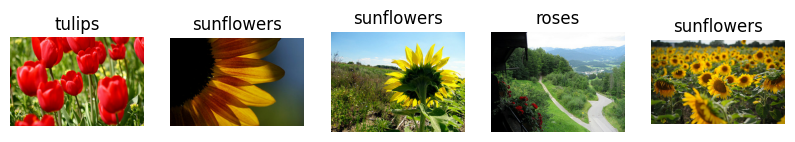

In [ ]:
# Mostramos una imagen por cada clase

import matplotlib.pyplot as plt

# Creamos una figura con subplots para mostrar una imagen por clase
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_images.take(num_classes)):
    image = np.squeeze(image, axis=0)
    label = np.squeeze(label, axis=0)
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(image)
    plt.title(class_names[label])
    plt.axis("off")


In [ ]:
# Buscamos el minimo y maximo valor entre todos las muestas

min_value = tf.reduce_min([tf.reduce_min(image) for image, _ in train_images])
max_value = tf.reduce_max([tf.reduce_max(image) for image, _ in train_images])

print(f'Valor mínimo: {min_value}')
print(f'Valor máximo: {max_value}')


Valor mínimo: 0
Valor máximo: 255


Parece que las imágenes van de un rango de 0 a 255, y al tener 3 filtros, lo más probable es que sean pixeles en formato RGB

### Preprocesamiento

In [ ]:
# Ajustamos el tamaño de las imágenes para que sea el mismo 224 x 224 x 3

# Definimos el tamaño de la imagen
IMG_SIZE = 224

# Redimensionamos las imágenes
train_images = train_images.map(lambda image, label: (tf.image.resize(image, (IMG_SIZE, IMG_SIZE)), label))
test_images = test_images.map(lambda image, label: (tf.image.resize(image, (IMG_SIZE, IMG_SIZE)), label))

# Verificamos el cambio
for image, _ in train_images.take(5):
  print(tf.shape(image))


tf.Tensor([  1 224 224   3], shape=(4,), dtype=int32)
tf.Tensor([  1 224 224   3], shape=(4,), dtype=int32)
tf.Tensor([  1 224 224   3], shape=(4,), dtype=int32)
tf.Tensor([  1 224 224   3], shape=(4,), dtype=int32)
tf.Tensor([  1 224 224   3], shape=(4,), dtype=int32)


Listo, ya todas nuestras imanges tienen el mismo tamaño

In [ ]:
# Normalizamos los valores de los pixeles
train_images = train_images.map(lambda image, label: (image / 255.0, label))
test_images = test_images.map(lambda image, label: (image / 255.0, label))

Ahora todos nuestros valores están entre 0 y 1

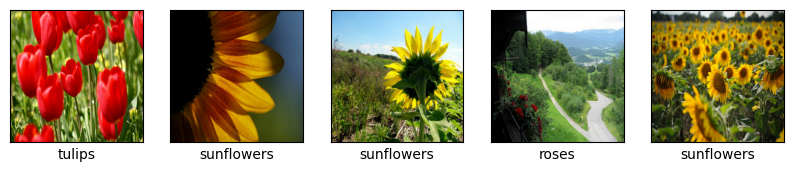

In [ ]:
# Mostramos 5 imágenes para comprobar que no se ha roto nada

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_images.take(5)):
    image = np.squeeze(image, axis=0)
    label = np.squeeze(label, axis=0)
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
plt.show()


Como vemos nuestras imágenes se mantienen igual, pero ahora mismo tamaño

## Implementación del modelo

Alexnet es la red neural que inició el mundo del deep learning, pues con 5 capas convolucionales y 3 completamente conectadas, fue pionero en aplicar profundidad (deep) al aprendizaje al aprovechar el cómputo en paralelo de las GPUs.

El modelo see puede ver en la siguiente figura a la derecha

![From LeNet (left) to AlexNet (right).](http://d2l.ai/_images/alexnet.svg)

In [ ]:
# Crea el modelo Alexnet usando keras

from keras import layers, models

# Definimos el modelo
model = models.Sequential([
    layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 26, 26, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 384)       1

In [ ]:
# Entrenamos el modelo por 5 iteraciones sobre el conjunto de datos

history = model.fit(train_images,
                    epochs=5,
                    validation_data=test_images)


Epoch 1/5
2936/2936 [==============================] - 67s 20ms/step - loss: 1.6101 - accuracy: 0.2422 - val_loss: 1.6134 - val_accuracy: 0.2166
Epoch 2/5
2936/2936 [==============================] - 64s 22ms/step - loss: 1.6023 - accuracy: 0.2449 - val_loss: 1.6112 - val_accuracy: 0.2166
Epoch 3/5
2936/2936 [==============================] - 66s 22ms/step - loss: 1.6023 - accuracy: 0.2500 - val_loss: 1.6088 - val_accuracy: 0.2166
Epoch 4/5
2936/2936 [==============================] - 67s 23ms/step - loss: 1.6026 - accuracy: 0.2514 - val_loss: 1.6078 - val_accuracy: 0.2166
Epoch 5/5
2936/2936 [==============================] - 61s 21ms/step - loss: 1.6016 - accuracy: 0.2517 - val_loss: 1.6071 - val_accuracy: 0.2166


Vaya, el modelo es patético. A duras penas es capaz de predecir correctamente el 20% de las muestras. Aunque considerando que la exactitud de este modelo rondaba el 15% era esperado.

Con el tiempo los modelos fueron evolucionando, y hoy tenemos redes mucho más potentes.

Probablemente el problema la IA es que las imágenes no solo contienen las flores, sino otros elementos

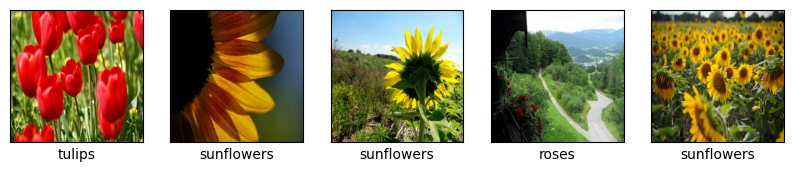

Como alternativa, podemos usar una arquitectura de red neural convolucional llamadas SSD (Single shot multibox detectors) Modelos especializados en distinguir objetos en una imagen. Para este caso podemos usar Mobile net, un modelo desarrollado por Google en el 2020, aunque hay muchos más modelos especializados

## Aprendizaje por transferencia

Como ya vimos, entrenar nuestros modelos no solo tarda mucho, sino que lo más probable es que luego los resultados que arroje sean muy patéticos. Por esto en la actualidad, la mayoría de proyectos de aplicación se caracterizan por entrenar modelos ya entrenados para realizar una tarea. En este caso usaremos Mobile net

In [ ]:
from tensorflow import keras

# Creamos el modelo preentrenado de keras

feature_extractor = keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False, # La cabeza del modelo se encarga de clasificar, por lo que no nos sirve la del modelo
    weights="imagenet", # Cargamos los parámetros del modelo entrenado con Imagenet
)

9406464/9406464 [==============================] - 0s 0us/step


Tenemos que eliminar el tope del modelo, porque el tope es la capa de clasificación o predicción final. En el caso de el tope de un modelo para imagenet, es una capa con 1000 neuronas de salida, cada una asociada a una etiqueta. En nuestro caso, solo tenemos 5 flores, así que no nos sirve.

Usaremos MobileNet como un feature extractor, y nos dedicaremos a entrenar la red neural densa que se encargue de clasificar esas features en cualquiera de las 5 clases de flores que tenemos

In [ ]:
# Congelamos la red convolucional para que no se entrene

feature_extractor.trainable = False

Al marcar como trainable `false`, los parámetros del modelo van a permanecer inmutables, por lo que la propagación no llegará hasta el principio en el entranamiento, sino hasta la salida del nuevo modelo.

In [ ]:
# Ahora creamos un nuevo modelo con primera capa la red convolucional y una capa densa de clasificación

model = keras.Sequential([
  feature_extractor, # la primera capa es el modelo
  layers.GlobalAveragePooling2D(), # reducimos los filtros 7x7x1280 a una dimensión 1280 aplicando un promedio general. # Flatten también era válido pero el modelo tardaría más en entrenar
  layers.Dense(num_classes, activation='softmax') # Capa de clasificación
])

model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_3 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


Como vemos, la capa de entrada es mobilenetv2, que tiene 2257984 parámetros, y una salida de 7x7x1280, que luego sirve de entrada a una capa de pooling de promedio general, la cuál calcula el promedio de cada filtro 7x7, y lo aplana para generar una salida de forma unidimensional con 1280 dimensiones en el mismo eje. Finalmente esas 1280 parámetros son conectados a una red densa de 5 neuronas, de las cuales en un trabajo de clasificación se tomará aquella que mejor se active con la función softmax

In [ ]:
# Entrenamos el modelo

history = model.fit(train_images,
                    epochs=5,
                    validation_data=test_images)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


2936/2936 [==============================] - 33s 9ms/step - loss: 0.5783 - accuracy: 0.7973 - val_loss: 0.4278 - val_accuracy: 0.8624
Epoch 2/5
2936/2936 [==============================] - 29s 10ms/step - loss: 0.3035 - accuracy: 0.8948 - val_loss: 0.3972 - val_accuracy: 0.8733
Epoch 3/5
2936/2936 [==============================] - 27s 9ms/step - loss: 0.2040 - accuracy: 0.9356 - val_loss: 0.4111 - val_accuracy: 0.8774
Epoch 4/5
2936/2936 [==============================] - 26s 9ms/step - loss: 0.1396 - accuracy: 0.9619 - val_loss: 0.4161 - val_accuracy: 0.8842
Epoch 5/5
2936/2936 [==============================] - 27s 9ms/step - loss: 0.0965 - accuracy: 0.9762 - val_loss: 0.4637 - val_accuracy: 0.8856


Como ves, en la mitad de tiempo y corridas se consiguió un modelo con una exactitud 4 veces mayor y muy cercana al 90%!

Esto funciona porque recordemos que las redes convolucionales extraen las features, y el modelo que escogimos está perfectamente entrenado para la tarea. Nuestra misión fue tomar ese modelo ya entrenado y ajustarlo a nuestra tarea que probablemente no tiene un modelo ya existente. Para ello dejamos la capa de extracción de features y reentrenamos con nuestra capa de clasificación

## Despliegue

In [ ]:
# Descarga imagen de internet con python

import requests
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
from urllib.request import urlopen
import numpy as np


def download_image(url: str):
  # Send a GET request to the URL
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Read the image data from the response
      image_data = response.content

      # Create an image object from the data
      image = Image.open(BytesIO(image_data)).convert("RGB")

      image = image.resize((IMG_SIZE, IMG_SIZE))

      data = np.array(image)/255.0

      # Return the data of the image
      return data
  else:
      print("Failed to download the image.", response.status_code)

In [ ]:
def identify(url: str):
  image = download_image(url)
  probabilities = model.predict(np.expand_dims(image, axis=0))
  class_index = np.argmax(probabilities)
  print(class_index)
  return {
      "name": class_names[class_index]
  }

In [ ]:
identify("https://veggiegardenseeds.com.au/cdn/shop/products/image_433c45a2-12e5-4560-b5e7-2d21f9a2ec07.webp?v=1698192153")

1/1 [==============================] - 1s 821ms/step
3


{'name': 'sunflowers'}

In [ ]:
!pip install --ignore-installed Flask==3.0.0 pyngrok==7.1.2
ngrok_key = "Coloca tu clave de ngrok aquí"
port = 5000

from pyngrok import ngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.2/133.2 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.5/705.5 kB 13.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.2.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which 

In [ ]:
ngrok.set_auth_token(ngrok_key)
ngrok.connect(port)

<NgrokTunnel: "https://d239-35-184-123-255.ngrok-free.app" -> "http://localhost:5000">

In [ ]:
from IPython.display import IFrame
IFrame(src="https://projects.rolandoandrade.me/identity/", width=500, height=500)

# https://cdn.globalrose.com/assets/img/prod/choose-your-quantity-of-roses-globalrose.png
# https://veggiegardenseeds.com.au/cdn/shop/products/image_433c45a2-12e5-4560-b5e7-2d21f9a2ec07.webp?v=1698192153
# https://www.floraldesigninstitute.com/cdn/shop/articles/Tulip-Single-Rounded-299x315.jpg?v=1651708280
# https://www.wholesalenurseryco.com/cdn/shop/files/OxeyeDaisy_1_1_1.jpg?v=1709935028
# https://www.cardinallawns.com/wp-content/uploads/2018/10/Dandelion.jpg


In [ ]:
from flask import Flask, request, jsonify, Response
import json

app = Flask(__name__)

@app.route("/")
def hello():
  image_url = request.args.get('image_url')
  response = identify(image_url)
  return Response(json.dumps(response), headers=[('Access-Control-Allow-Origin', '*')])

if __name__ == '__main__':
    app.run(port = port)

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
ERROR:__main__:Exception on / [GET]
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 1455, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 869, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 867, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 852, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "<ipython-input-21-849f70dde778>", line 9, in hello
    response = identify(image_url)
  File "<ipython-input-16-d2c574d9da8a>", line 3, in identify
 

Failed to download the image. 404
1/1 [==============================] - 0s 22ms/step


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
INFO:werkzeug:127.0.0.1 - - [29/Apr/2024 12:41:00] "GET /?image_url=https://cdn.globalrose.com/assets/img/prod/choose-your-quantity-of-roses-globalrose.png HTTP/1.1" 200 -


4
1/1 [==============================] - 0s 24ms/step


INFO:werkzeug:127.0.0.1 - - [29/Apr/2024 12:41:39] "GET /?image_url=https://veggiegardenseeds.com.au/cdn/shop/products/image_433c45a2-12e5-4560-b5e7-2d21f9a2ec07.webp?v=1698192153 HTTP/1.1" 200 -


3
1/1 [==============================] - 0s 23ms/step


INFO:werkzeug:127.0.0.1 - - [29/Apr/2024 12:41:43] "GET /?image_url=https://www.floraldesigninstitute.com/cdn/shop/articles/Tulip-Single-Rounded-299x315.jpg?v=1651708280 HTTP/1.1" 200 -


2
1/1 [==============================] - 0s 23ms/step


INFO:werkzeug:127.0.0.1 - - [29/Apr/2024 12:41:46] "GET /?image_url=https://www.wholesalenurseryco.com/cdn/shop/files/OxeyeDaisy_1_1_1.jpg?v=1709935028 HTTP/1.1" 200 -


1
1/1 [==============================] - 0s 21ms/step


INFO:werkzeug:127.0.0.1 - - [29/Apr/2024 12:41:51] "GET /?image_url=https://www.cardinallawns.com/wp-content/uploads/2018/10/Dandelion.jpg HTTP/1.1" 200 -


0


# Conclusiones

Las redes convolcionales son muy potentes para extraer features, pero son muy lentas en entrenar. Luego de la extracción  de features la red convolucional termina en una red neural densa que se encarga de clasificar o predecir.

Gracias al aprendizaje por transferencia, podemos usar modelos entrenados para una tarea, para resolver otras sin tener que entrenar todo el modelo. En este caso se tomó un modelo de Alexnet ya entrenado y simplemente se le removió la capa densa para aprender a reclasificar las flores

# Tu turno

Resuelva el mismo problema usando fashion mnist `keras.datasets.fashion_mnist.load_data()` [Documentación](https://keras.io/api/datasets/fashion_mnist/)

Por otro lado, en teoría con este modelo puede resolver muchísimos problemas de visión por computador, como análisis de imágenes médicas como tumores, identificación facial, etc. El límite está en los pesos con los que elija el modelo

# La verdadera solución al problema

La verdad, esta es la manera correcta de solucionar el problema, pero es muy costosa salvo que se despliegue en servicios de inferencia (servidores que se duermen si no se usan) como `Cloudflare AI Workers`. Lo que yo haría es entrenar el modelo como se hizo aquí, guardar los pesos con `<model>.save_weights()` y almacenar los pesos en algún servicio como `S3`, `R2`, `Dropox`, o incluso `Google Drive`. Luego usaría una API como `Hugging face` o `Replicate` del modelo `MobilenetV2` y lo cargaría indicando en el parámetro `weights` el url de los pesos que almacené. De esta forma, los costos pasarían de (0.X - XX) USD la hora, a 0.000XXX USD por inferencia